In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from IPython.display import SVG

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import CSVLogger, ModelCheckpoint

np.random.seed(1234)

%matplotlib inline

Using TensorFlow backend.


In [2]:
boston = load_boston()

boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
boston_df['y'] = boston['target']

x_cols = boston['feature_names']

print(boston['DESCR'])
boston_df.head()

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Split data intro train, valid and test

In [3]:
train_df, test_df = train_test_split(boston_df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.2)

train_df = train_df.copy()
test_df = test_df.copy()
valid_df = valid_df.copy()

print('#train:', len(train_df), '#valid:', len(valid_df), '#test:', len(test_df))

#train: 323 #valid: 81 #test: 102


## Let's scale our data

In [4]:
scaller = StandardScaler()

train_df[x_cols] = scaller.fit_transform(train_df[x_cols])
test_df[x_cols] = scaller.transform(test_df[x_cols])
valid_df[x_cols] = scaller.transform(valid_df[x_cols])

train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
28,-0.327391,-0.449163,-0.465665,-0.263698,-0.185207,0.300997,0.891137,0.390173,-0.649358,-0.608270,1.174704,0.367454,0.011949,18.4
171,-0.126111,-0.449163,1.226777,-0.263698,0.387726,-0.594153,0.996278,-0.681422,-0.535553,-0.040160,-1.728739,-0.042720,-0.098447,19.1
392,1.083986,-0.449163,1.007825,-0.263698,1.200094,-1.822618,0.985402,-1.002330,1.626742,1.516223,0.806013,0.459771,1.858573,9.7
497,-0.393305,-0.449163,-0.236357,-0.263698,0.216701,-0.719328,0.028252,-0.420006,-0.421748,-0.111174,0.345149,0.459771,0.198332,18.3
180,-0.419756,-0.449163,-1.305969,-0.263698,-0.612769,2.149516,0.488699,-0.498690,-0.763163,-1.282900,-0.300061,0.445965,-0.739317,39.8


## Let's back to matrices

In [5]:
X_train, y_train = train_df[x_cols].values, train_df['y'].values
X_test, y_test = test_df[x_cols].values, test_df['y'].values
X_valid, y_valid = valid_df[x_cols].values, valid_df['y'].values

## Set up network

In [6]:
model = Sequential([
    Dense(len(x_cols), input_dim=len(x_cols), kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal')
])

model.compile('adam', loss='mean_squared_error')

### Plot the model

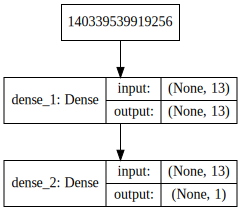

In [7]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, batch_size=16, epochs=600, validation_data=(X_valid, y_valid))

Train on 323 samples, validate on 81 samples
Epoch 1/600
323/323 [==============================] - 1s 2ms/step - loss: 565.9739 - val_loss: 632.1962
Epoch 2/600
323/323 [==============================] - 0s 74us/step - loss: 562.4569 - val_loss: 627.4589
Epoch 3/600
323/323 [==============================] - 0s 79us/step - loss: 557.1389 - val_loss: 620.3053
Epoch 4/600
323/323 [==============================] - 0s 75us/step - loss: 549.1642 - val_loss: 610.3551
Epoch 5/600
323/323 [==============================] - 0s 74us/step - loss: 538.5475 - val_loss: 596.7493
Epoch 6/600
323/323 [==============================] - 0s 74us/step - loss: 524.8892 - val_loss: 580.3748
Epoch 7/600
323/323 [==============================] - 0s 73us/step - loss: 508.5978 - val_loss: 560.6034
Epoch 8/600
323/323 [==============================] - 0s 77us/step - loss: 489.2981 - val_loss: 538.7389
Epoch 9/600
323/323 [==============================] - 0s 73us/step - loss: 467.6881 - val_loss: 513.8119
Ep

323/323 [==============================] - 0s 74us/step - loss: 21.7258 - val_loss: 34.8719
Epoch 79/600
323/323 [==============================] - 0s 72us/step - loss: 21.5997 - val_loss: 34.6706
Epoch 80/600
323/323 [==============================] - 0s 73us/step - loss: 21.4637 - val_loss: 34.5112
Epoch 81/600
323/323 [==============================] - 0s 72us/step - loss: 21.3731 - val_loss: 34.4278
Epoch 82/600
323/323 [==============================] - 0s 74us/step - loss: 21.2369 - val_loss: 34.2041
Epoch 83/600
323/323 [==============================] - 0s 79us/step - loss: 21.1406 - val_loss: 33.9855
Epoch 84/600
323/323 [==============================] - 0s 74us/step - loss: 21.0129 - val_loss: 33.8805
Epoch 85/600
323/323 [==============================] - 0s 71us/step - loss: 20.9249 - val_loss: 33.7195
Epoch 86/600
323/323 [==============================] - 0s 74us/step - loss: 20.7608 - val_loss: 33.6589
Epoch 87/600
323/323 [==============================] - 0s 76us/step

323/323 [==============================] - 0s 71us/step - loss: 15.1112 - val_loss: 26.0282
Epoch 156/600
323/323 [==============================] - 0s 74us/step - loss: 15.0229 - val_loss: 26.0342
Epoch 157/600
323/323 [==============================] - 0s 73us/step - loss: 14.9721 - val_loss: 25.9094
Epoch 158/600
323/323 [==============================] - 0s 74us/step - loss: 14.9333 - val_loss: 25.8198
Epoch 159/600
323/323 [==============================] - 0s 74us/step - loss: 14.8557 - val_loss: 25.7021
Epoch 160/600
323/323 [==============================] - 0s 72us/step - loss: 14.7834 - val_loss: 25.6673
Epoch 161/600
323/323 [==============================] - 0s 75us/step - loss: 14.7363 - val_loss: 25.5646
Epoch 162/600
323/323 [==============================] - 0s 75us/step - loss: 14.7095 - val_loss: 25.4592
Epoch 163/600
323/323 [==============================] - 0s 78us/step - loss: 14.6361 - val_loss: 25.3736
Epoch 164/600
323/323 [==============================] - 0s 

323/323 [==============================] - 0s 74us/step - loss: 11.2491 - val_loss: 20.3435
Epoch 233/600
323/323 [==============================] - 0s 73us/step - loss: 11.1516 - val_loss: 20.3464
Epoch 234/600
323/323 [==============================] - 0s 74us/step - loss: 11.1140 - val_loss: 20.3226
Epoch 235/600
323/323 [==============================] - 0s 74us/step - loss: 11.0733 - val_loss: 20.4460
Epoch 236/600
323/323 [==============================] - 0s 76us/step - loss: 11.0691 - val_loss: 20.3841
Epoch 237/600
323/323 [==============================] - 0s 73us/step - loss: 11.0213 - val_loss: 20.2859
Epoch 238/600
323/323 [==============================] - 0s 73us/step - loss: 10.9684 - val_loss: 20.2683
Epoch 239/600
323/323 [==============================] - 0s 74us/step - loss: 10.9517 - val_loss: 20.3918
Epoch 240/600
323/323 [==============================] - 0s 74us/step - loss: 10.9248 - val_loss: 20.1465
Epoch 241/600
323/323 [==============================] - 0s 

323/323 [==============================] - 0s 74us/step - loss: 9.5569 - val_loss: 17.5934
Epoch 310/600
323/323 [==============================] - 0s 75us/step - loss: 9.6026 - val_loss: 17.6680
Epoch 311/600
323/323 [==============================] - 0s 72us/step - loss: 9.5320 - val_loss: 17.6837
Epoch 312/600
323/323 [==============================] - 0s 72us/step - loss: 9.5440 - val_loss: 17.6801
Epoch 313/600
323/323 [==============================] - 0s 78us/step - loss: 9.5651 - val_loss: 17.9118
Epoch 314/600
323/323 [==============================] - 0s 73us/step - loss: 9.4956 - val_loss: 17.6957
Epoch 315/600
323/323 [==============================] - 0s 77us/step - loss: 9.4859 - val_loss: 17.6824
Epoch 316/600
323/323 [==============================] - 0s 73us/step - loss: 9.4919 - val_loss: 17.7246
Epoch 317/600
323/323 [==============================] - 0s 73us/step - loss: 9.4791 - val_loss: 17.6772
Epoch 318/600
323/323 [==============================] - 0s 74us/step

323/323 [==============================] - 0s 76us/step - loss: 9.0282 - val_loss: 16.6852
Epoch 388/600
323/323 [==============================] - 0s 73us/step - loss: 9.0927 - val_loss: 16.8153
Epoch 389/600
323/323 [==============================] - 0s 78us/step - loss: 8.9962 - val_loss: 16.8183
Epoch 390/600
323/323 [==============================] - 0s 75us/step - loss: 9.0390 - val_loss: 16.8524
Epoch 391/600
323/323 [==============================] - 0s 74us/step - loss: 9.0330 - val_loss: 16.7860
Epoch 392/600
323/323 [==============================] - 0s 75us/step - loss: 9.0141 - val_loss: 16.8059
Epoch 393/600
323/323 [==============================] - 0s 73us/step - loss: 9.0059 - val_loss: 16.8073
Epoch 394/600
323/323 [==============================] - 0s 75us/step - loss: 8.9972 - val_loss: 16.8564
Epoch 395/600
323/323 [==============================] - 0s 72us/step - loss: 8.9896 - val_loss: 16.8289
Epoch 396/600
323/323 [==============================] - 0s 73us/step

323/323 [==============================] - 0s 73us/step - loss: 8.7065 - val_loss: 16.8206
Epoch 466/600
323/323 [==============================] - 0s 72us/step - loss: 8.7037 - val_loss: 16.7718
Epoch 467/600
323/323 [==============================] - 0s 74us/step - loss: 8.7076 - val_loss: 16.7750
Epoch 468/600
323/323 [==============================] - 0s 75us/step - loss: 8.7333 - val_loss: 16.8095
Epoch 469/600
323/323 [==============================] - 0s 75us/step - loss: 8.7383 - val_loss: 16.8862
Epoch 470/600
323/323 [==============================] - 0s 73us/step - loss: 8.7163 - val_loss: 16.7018
Epoch 471/600
323/323 [==============================] - 0s 75us/step - loss: 8.6799 - val_loss: 16.7227
Epoch 472/600
323/323 [==============================] - 0s 75us/step - loss: 8.6905 - val_loss: 16.7401
Epoch 473/600
323/323 [==============================] - 0s 76us/step - loss: 8.7030 - val_loss: 16.5755
Epoch 474/600
323/323 [==============================] - 0s 77us/step

323/323 [==============================] - 0s 73us/step - loss: 8.2627 - val_loss: 16.0426
Epoch 544/600
323/323 [==============================] - 0s 72us/step - loss: 8.3086 - val_loss: 16.2089
Epoch 545/600
323/323 [==============================] - 0s 72us/step - loss: 8.2258 - val_loss: 16.2005
Epoch 546/600
323/323 [==============================] - 0s 73us/step - loss: 8.2360 - val_loss: 16.1627
Epoch 547/600
323/323 [==============================] - 0s 75us/step - loss: 8.2429 - val_loss: 16.2473
Epoch 548/600
323/323 [==============================] - 0s 78us/step - loss: 8.2157 - val_loss: 16.1580
Epoch 549/600
323/323 [==============================] - 0s 72us/step - loss: 8.2295 - val_loss: 16.2083
Epoch 550/600
323/323 [==============================] - 0s 75us/step - loss: 8.1881 - val_loss: 16.2270
Epoch 551/600
323/323 [==============================] - 0s 72us/step - loss: 8.2067 - val_loss: 16.2686
Epoch 552/600
323/323 [==============================] - 0s 77us/step

In [10]:
y_pred = model.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

MSE: 12.670261108010363
R^2: 0.87656692280297


## Excersize: try to overfit modifying NN structure (add layers, make them wider)

In [11]:
model = Sequential([
    Dense(64, input_dim=len(x_cols), kernel_initializer='normal', activation='relu'),
    Dense(64, kernel_initializer='normal'),
    Dense(64, kernel_initializer='normal'),
    Dense(64, kernel_initializer='normal'),
    Dense(64, kernel_initializer='normal'),
    Dense(1, kernel_initializer='normal'),
])

model.compile('adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=16, epochs=1600, validation_data=(X_valid, y_valid))

Train on 323 samples, validate on 81 samples
Epoch 1/1600
323/323 [==============================] - 0s 737us/step - loss: 552.9181 - val_loss: 532.8733
Epoch 2/1600
323/323 [==============================] - 0s 117us/step - loss: 209.2976 - val_loss: 73.7632
Epoch 3/1600
323/323 [==============================] - 0s 116us/step - loss: 37.7434 - val_loss: 44.8642
Epoch 4/1600
323/323 [==============================] - 0s 120us/step - loss: 21.5782 - val_loss: 35.2080
Epoch 5/1600
323/323 [==============================] - 0s 117us/step - loss: 18.3808 - val_loss: 30.2035
Epoch 6/1600
323/323 [==============================] - 0s 117us/step - loss: 16.5986 - val_loss: 27.3629
Epoch 7/1600
323/323 [==============================] - 0s 119us/step - loss: 14.2246 - val_loss: 25.7052
Epoch 8/1600
323/323 [==============================] - 0s 114us/step - loss: 15.5459 - val_loss: 23.5273
Epoch 9/1600
323/323 [==============================] - 0s 118us/step - loss: 12.8187 - val_loss: 24.095

Epoch 78/1600
323/323 [==============================] - 0s 116us/step - loss: 5.1885 - val_loss: 15.1946
Epoch 79/1600
323/323 [==============================] - 0s 122us/step - loss: 5.3400 - val_loss: 15.9309
Epoch 80/1600
323/323 [==============================] - 0s 117us/step - loss: 6.1586 - val_loss: 18.0679
Epoch 81/1600
323/323 [==============================] - 0s 116us/step - loss: 5.3329 - val_loss: 15.9923
Epoch 82/1600
323/323 [==============================] - 0s 120us/step - loss: 5.1810 - val_loss: 16.7544
Epoch 83/1600
323/323 [==============================] - 0s 115us/step - loss: 5.2497 - val_loss: 15.9869
Epoch 84/1600
323/323 [==============================] - 0s 116us/step - loss: 5.3220 - val_loss: 15.2791
Epoch 85/1600
323/323 [==============================] - 0s 120us/step - loss: 6.1406 - val_loss: 20.8462
Epoch 86/1600
323/323 [==============================] - 0s 116us/step - loss: 5.1040 - val_loss: 17.5409
Epoch 87/1600
323/323 [=======================

Epoch 155/1600
323/323 [==============================] - 0s 115us/step - loss: 3.2766 - val_loss: 17.7643
Epoch 156/1600
323/323 [==============================] - 0s 115us/step - loss: 3.4813 - val_loss: 17.7309
Epoch 157/1600
323/323 [==============================] - 0s 121us/step - loss: 3.8408 - val_loss: 16.4305
Epoch 158/1600
323/323 [==============================] - 0s 118us/step - loss: 4.1843 - val_loss: 13.9146
Epoch 159/1600
323/323 [==============================] - 0s 115us/step - loss: 3.2480 - val_loss: 14.8728
Epoch 160/1600
323/323 [==============================] - 0s 118us/step - loss: 3.0996 - val_loss: 15.0182
Epoch 161/1600
323/323 [==============================] - 0s 120us/step - loss: 3.3799 - val_loss: 14.2948
Epoch 162/1600
323/323 [==============================] - 0s 114us/step - loss: 3.3579 - val_loss: 13.8052
Epoch 163/1600
323/323 [==============================] - 0s 117us/step - loss: 3.3259 - val_loss: 15.4288
Epoch 164/1600
323/323 [=============

323/323 [==============================] - 0s 116us/step - loss: 2.0973 - val_loss: 17.6263
Epoch 232/1600
323/323 [==============================] - 0s 116us/step - loss: 2.6541 - val_loss: 15.4829
Epoch 233/1600
323/323 [==============================] - 0s 118us/step - loss: 2.9581 - val_loss: 17.7026
Epoch 234/1600
323/323 [==============================] - 0s 118us/step - loss: 2.3569 - val_loss: 14.5532
Epoch 235/1600
323/323 [==============================] - 0s 114us/step - loss: 2.4731 - val_loss: 17.3045
Epoch 236/1600
323/323 [==============================] - 0s 121us/step - loss: 2.8169 - val_loss: 15.8282
Epoch 237/1600
323/323 [==============================] - 0s 115us/step - loss: 2.2400 - val_loss: 14.3474
Epoch 238/1600
323/323 [==============================] - 0s 118us/step - loss: 2.2231 - val_loss: 16.3795
Epoch 239/1600
323/323 [==============================] - 0s 120us/step - loss: 3.2088 - val_loss: 22.1548
Epoch 240/1600
323/323 [============================

323/323 [==============================] - 0s 115us/step - loss: 2.2270 - val_loss: 16.1749
Epoch 308/1600
323/323 [==============================] - 0s 121us/step - loss: 1.8352 - val_loss: 18.8401
Epoch 309/1600
323/323 [==============================] - 0s 115us/step - loss: 2.3283 - val_loss: 17.3770
Epoch 310/1600
323/323 [==============================] - 0s 116us/step - loss: 2.9225 - val_loss: 16.0616
Epoch 311/1600
323/323 [==============================] - 0s 119us/step - loss: 2.1935 - val_loss: 17.2164
Epoch 312/1600
323/323 [==============================] - 0s 114us/step - loss: 1.7734 - val_loss: 16.9457
Epoch 313/1600
323/323 [==============================] - 0s 115us/step - loss: 1.9267 - val_loss: 16.9849
Epoch 314/1600
323/323 [==============================] - 0s 120us/step - loss: 2.9052 - val_loss: 18.6766
Epoch 315/1600
323/323 [==============================] - 0s 116us/step - loss: 2.6504 - val_loss: 16.7374
Epoch 316/1600
323/323 [============================

323/323 [==============================] - 0s 121us/step - loss: 1.4368 - val_loss: 16.7603
Epoch 384/1600
323/323 [==============================] - 0s 113us/step - loss: 1.6179 - val_loss: 16.2023
Epoch 385/1600
323/323 [==============================] - 0s 116us/step - loss: 1.6391 - val_loss: 16.0974
Epoch 386/1600
323/323 [==============================] - 0s 120us/step - loss: 1.3341 - val_loss: 17.7356
Epoch 387/1600
323/323 [==============================] - 0s 118us/step - loss: 1.3065 - val_loss: 17.9802
Epoch 388/1600
323/323 [==============================] - 0s 115us/step - loss: 1.8090 - val_loss: 17.4492
Epoch 389/1600
323/323 [==============================] - 0s 122us/step - loss: 1.4039 - val_loss: 17.7633
Epoch 390/1600
323/323 [==============================] - 0s 114us/step - loss: 1.9025 - val_loss: 15.9416
Epoch 391/1600
323/323 [==============================] - 0s 116us/step - loss: 1.8459 - val_loss: 16.2855
Epoch 392/1600
323/323 [============================

323/323 [==============================] - 0s 115us/step - loss: 1.7578 - val_loss: 17.3067
Epoch 460/1600
323/323 [==============================] - 0s 116us/step - loss: 1.5257 - val_loss: 16.7187
Epoch 461/1600
323/323 [==============================] - 0s 118us/step - loss: 1.1599 - val_loss: 16.1425
Epoch 462/1600
323/323 [==============================] - 0s 117us/step - loss: 1.3273 - val_loss: 17.0557
Epoch 463/1600
323/323 [==============================] - 0s 116us/step - loss: 1.3988 - val_loss: 17.8799
Epoch 464/1600
323/323 [==============================] - 0s 117us/step - loss: 1.1117 - val_loss: 17.1087
Epoch 465/1600
323/323 [==============================] - 0s 118us/step - loss: 1.1900 - val_loss: 19.4311
Epoch 466/1600
323/323 [==============================] - 0s 119us/step - loss: 1.4015 - val_loss: 17.0953
Epoch 467/1600
323/323 [==============================] - 0s 117us/step - loss: 1.2716 - val_loss: 17.3803
Epoch 468/1600
323/323 [============================

323/323 [==============================] - 0s 116us/step - loss: 2.2290 - val_loss: 16.7770
Epoch 536/1600
323/323 [==============================] - 0s 122us/step - loss: 1.2180 - val_loss: 18.9083
Epoch 537/1600
323/323 [==============================] - 0s 120us/step - loss: 1.3624 - val_loss: 18.9715
Epoch 538/1600
323/323 [==============================] - 0s 115us/step - loss: 1.1419 - val_loss: 15.1601
Epoch 539/1600
323/323 [==============================] - 0s 115us/step - loss: 1.2583 - val_loss: 18.2858
Epoch 540/1600
323/323 [==============================] - 0s 120us/step - loss: 1.1170 - val_loss: 17.5746
Epoch 541/1600
323/323 [==============================] - 0s 116us/step - loss: 1.1259 - val_loss: 16.8983
Epoch 542/1600
323/323 [==============================] - 0s 115us/step - loss: 1.2412 - val_loss: 18.3887
Epoch 543/1600
323/323 [==============================] - 0s 121us/step - loss: 1.2489 - val_loss: 15.9835
Epoch 544/1600
323/323 [============================

323/323 [==============================] - 0s 116us/step - loss: 1.1328 - val_loss: 15.9375
Epoch 612/1600
323/323 [==============================] - 0s 117us/step - loss: 1.0712 - val_loss: 17.8806
Epoch 613/1600
323/323 [==============================] - 0s 116us/step - loss: 1.8833 - val_loss: 16.2909
Epoch 614/1600
323/323 [==============================] - 0s 117us/step - loss: 1.6138 - val_loss: 18.0541
Epoch 615/1600
323/323 [==============================] - 0s 126us/step - loss: 1.3212 - val_loss: 17.6842
Epoch 616/1600
323/323 [==============================] - 0s 118us/step - loss: 1.3887 - val_loss: 16.0434
Epoch 617/1600
323/323 [==============================] - 0s 115us/step - loss: 1.1632 - val_loss: 17.3765
Epoch 618/1600
323/323 [==============================] - 0s 120us/step - loss: 1.0350 - val_loss: 16.8418
Epoch 619/1600
323/323 [==============================] - 0s 115us/step - loss: 1.7838 - val_loss: 17.8994
Epoch 620/1600
323/323 [============================

323/323 [==============================] - 0s 123us/step - loss: 1.0784 - val_loss: 17.8085
Epoch 688/1600
323/323 [==============================] - 0s 128us/step - loss: 1.5843 - val_loss: 19.0276
Epoch 689/1600
323/323 [==============================] - 0s 116us/step - loss: 1.0752 - val_loss: 16.3826
Epoch 690/1600
323/323 [==============================] - 0s 121us/step - loss: 1.7401 - val_loss: 17.6563
Epoch 691/1600
323/323 [==============================] - 0s 118us/step - loss: 1.2267 - val_loss: 16.9238
Epoch 692/1600
323/323 [==============================] - 0s 114us/step - loss: 1.1469 - val_loss: 17.3382
Epoch 693/1600
323/323 [==============================] - 0s 123us/step - loss: 1.1027 - val_loss: 16.7267
Epoch 694/1600
323/323 [==============================] - 0s 118us/step - loss: 1.0926 - val_loss: 16.5115
Epoch 695/1600
323/323 [==============================] - 0s 115us/step - loss: 1.2979 - val_loss: 17.0541
Epoch 696/1600
323/323 [============================

323/323 [==============================] - 0s 118us/step - loss: 1.3549 - val_loss: 16.0803
Epoch 764/1600
323/323 [==============================] - 0s 114us/step - loss: 1.0897 - val_loss: 16.3124
Epoch 765/1600
323/323 [==============================] - 0s 121us/step - loss: 0.8712 - val_loss: 17.8385
Epoch 766/1600
323/323 [==============================] - 0s 119us/step - loss: 0.9888 - val_loss: 18.2469
Epoch 767/1600
323/323 [==============================] - 0s 116us/step - loss: 0.9445 - val_loss: 16.8219
Epoch 768/1600
323/323 [==============================] - 0s 118us/step - loss: 0.8498 - val_loss: 17.7807
Epoch 769/1600
323/323 [==============================] - 0s 115us/step - loss: 0.9333 - val_loss: 18.5664
Epoch 770/1600
323/323 [==============================] - 0s 115us/step - loss: 1.1252 - val_loss: 20.3462
Epoch 771/1600
323/323 [==============================] - 0s 116us/step - loss: 1.1358 - val_loss: 17.2240
Epoch 772/1600
323/323 [============================

323/323 [==============================] - 0s 116us/step - loss: 0.9291 - val_loss: 15.6911
Epoch 840/1600
323/323 [==============================] - 0s 119us/step - loss: 0.9656 - val_loss: 18.6917
Epoch 841/1600
323/323 [==============================] - 0s 137us/step - loss: 1.0979 - val_loss: 16.8415
Epoch 842/1600
323/323 [==============================] - 0s 115us/step - loss: 0.7309 - val_loss: 17.3251
Epoch 843/1600
323/323 [==============================] - 0s 118us/step - loss: 0.6892 - val_loss: 17.5172
Epoch 844/1600
323/323 [==============================] - 0s 122us/step - loss: 0.9749 - val_loss: 16.6826
Epoch 845/1600
323/323 [==============================] - 0s 116us/step - loss: 1.2466 - val_loss: 17.4010
Epoch 846/1600
323/323 [==============================] - 0s 116us/step - loss: 2.2108 - val_loss: 20.3576
Epoch 847/1600
323/323 [==============================] - 0s 119us/step - loss: 1.8728 - val_loss: 17.0055
Epoch 848/1600
323/323 [============================

323/323 [==============================] - 0s 116us/step - loss: 0.6939 - val_loss: 17.0256
Epoch 916/1600
323/323 [==============================] - 0s 117us/step - loss: 0.6898 - val_loss: 17.2805
Epoch 917/1600
323/323 [==============================] - 0s 116us/step - loss: 0.7545 - val_loss: 18.3707
Epoch 918/1600
323/323 [==============================] - 0s 117us/step - loss: 0.7008 - val_loss: 18.1707
Epoch 919/1600
323/323 [==============================] - 0s 118us/step - loss: 0.6884 - val_loss: 17.8866
Epoch 920/1600
323/323 [==============================] - 0s 117us/step - loss: 0.7032 - val_loss: 16.5680
Epoch 921/1600
323/323 [==============================] - 0s 118us/step - loss: 0.7332 - val_loss: 16.9647
Epoch 922/1600
323/323 [==============================] - 0s 123us/step - loss: 0.8789 - val_loss: 17.8148
Epoch 923/1600
323/323 [==============================] - 0s 117us/step - loss: 0.8566 - val_loss: 18.2814
Epoch 924/1600
323/323 [============================

323/323 [==============================] - 0s 119us/step - loss: 0.8328 - val_loss: 16.9254
Epoch 992/1600
323/323 [==============================] - 0s 114us/step - loss: 0.7632 - val_loss: 17.9812
Epoch 993/1600
323/323 [==============================] - 0s 116us/step - loss: 0.5679 - val_loss: 18.0725
Epoch 994/1600
323/323 [==============================] - 0s 117us/step - loss: 0.8330 - val_loss: 17.1536
Epoch 995/1600
323/323 [==============================] - 0s 114us/step - loss: 0.7239 - val_loss: 17.6825
Epoch 996/1600
323/323 [==============================] - 0s 114us/step - loss: 0.6337 - val_loss: 17.7084
Epoch 997/1600
323/323 [==============================] - 0s 122us/step - loss: 0.6551 - val_loss: 16.6910
Epoch 998/1600
323/323 [==============================] - 0s 115us/step - loss: 1.3826 - val_loss: 19.1181
Epoch 999/1600
323/323 [==============================] - 0s 119us/step - loss: 0.9992 - val_loss: 16.8942
Epoch 1000/1600
323/323 [===========================

323/323 [==============================] - 0s 117us/step - loss: 1.0430 - val_loss: 16.1046
Epoch 1068/1600
323/323 [==============================] - 0s 114us/step - loss: 1.1807 - val_loss: 18.2380
Epoch 1069/1600
323/323 [==============================] - 0s 119us/step - loss: 1.2037 - val_loss: 16.1972
Epoch 1070/1600
323/323 [==============================] - 0s 115us/step - loss: 0.7365 - val_loss: 16.9118
Epoch 1071/1600
323/323 [==============================] - 0s 115us/step - loss: 0.7207 - val_loss: 16.6465
Epoch 1072/1600
323/323 [==============================] - 0s 117us/step - loss: 0.6219 - val_loss: 16.8718
Epoch 1073/1600
323/323 [==============================] - 0s 117us/step - loss: 0.6852 - val_loss: 16.7425
Epoch 1074/1600
323/323 [==============================] - 0s 116us/step - loss: 0.5383 - val_loss: 17.3541
Epoch 1075/1600
323/323 [==============================] - 0s 117us/step - loss: 0.7179 - val_loss: 16.8769
Epoch 1076/1600
323/323 [===================

323/323 [==============================] - 0s 115us/step - loss: 1.0441 - val_loss: 17.4982
Epoch 1144/1600
323/323 [==============================] - 0s 116us/step - loss: 0.6429 - val_loss: 18.1763
Epoch 1145/1600
323/323 [==============================] - 0s 117us/step - loss: 0.5650 - val_loss: 18.7695
Epoch 1146/1600
323/323 [==============================] - 0s 116us/step - loss: 0.6042 - val_loss: 18.9330
Epoch 1147/1600
323/323 [==============================] - 0s 117us/step - loss: 0.6219 - val_loss: 16.1559
Epoch 1148/1600
323/323 [==============================] - 0s 122us/step - loss: 0.5444 - val_loss: 19.2564
Epoch 1149/1600
323/323 [==============================] - 0s 120us/step - loss: 0.5747 - val_loss: 16.8605
Epoch 1150/1600
323/323 [==============================] - 0s 116us/step - loss: 0.6481 - val_loss: 18.9478
Epoch 1151/1600
323/323 [==============================] - 0s 118us/step - loss: 0.9901 - val_loss: 17.8684
Epoch 1152/1600
323/323 [===================

323/323 [==============================] - 0s 116us/step - loss: 0.5260 - val_loss: 17.5093
Epoch 1220/1600
323/323 [==============================] - 0s 120us/step - loss: 0.6167 - val_loss: 15.9648
Epoch 1221/1600
323/323 [==============================] - 0s 115us/step - loss: 0.6629 - val_loss: 18.1650
Epoch 1222/1600
323/323 [==============================] - 0s 114us/step - loss: 0.5535 - val_loss: 16.1246
Epoch 1223/1600
323/323 [==============================] - 0s 119us/step - loss: 0.6004 - val_loss: 17.4395
Epoch 1224/1600
323/323 [==============================] - 0s 118us/step - loss: 1.1601 - val_loss: 17.4364
Epoch 1225/1600
323/323 [==============================] - 0s 116us/step - loss: 0.7357 - val_loss: 16.4253
Epoch 1226/1600
323/323 [==============================] - 0s 120us/step - loss: 0.6196 - val_loss: 18.2426
Epoch 1227/1600
323/323 [==============================] - 0s 118us/step - loss: 0.6441 - val_loss: 17.9357
Epoch 1228/1600
323/323 [===================

323/323 [==============================] - 0s 117us/step - loss: 0.6560 - val_loss: 17.6915
Epoch 1296/1600
323/323 [==============================] - 0s 118us/step - loss: 0.6290 - val_loss: 17.2679
Epoch 1297/1600
323/323 [==============================] - 0s 118us/step - loss: 0.5714 - val_loss: 18.3562
Epoch 1298/1600
323/323 [==============================] - 0s 119us/step - loss: 0.5916 - val_loss: 18.0280
Epoch 1299/1600
323/323 [==============================] - 0s 121us/step - loss: 1.5600 - val_loss: 18.6051
Epoch 1300/1600
323/323 [==============================] - 0s 118us/step - loss: 0.7090 - val_loss: 18.7575
Epoch 1301/1600
323/323 [==============================] - 0s 116us/step - loss: 0.7272 - val_loss: 16.4643
Epoch 1302/1600
323/323 [==============================] - 0s 119us/step - loss: 0.7280 - val_loss: 16.8564
Epoch 1303/1600
323/323 [==============================] - 0s 117us/step - loss: 0.6830 - val_loss: 18.3797
Epoch 1304/1600
323/323 [===================

323/323 [==============================] - 0s 119us/step - loss: 0.5710 - val_loss: 18.8416
Epoch 1372/1600
323/323 [==============================] - 0s 118us/step - loss: 0.5825 - val_loss: 16.7924
Epoch 1373/1600
323/323 [==============================] - 0s 115us/step - loss: 0.8335 - val_loss: 19.9442
Epoch 1374/1600
323/323 [==============================] - 0s 119us/step - loss: 0.7023 - val_loss: 17.6666
Epoch 1375/1600
323/323 [==============================] - 0s 122us/step - loss: 0.5581 - val_loss: 17.3166
Epoch 1376/1600
323/323 [==============================] - 0s 116us/step - loss: 0.4789 - val_loss: 19.4978
Epoch 1377/1600
323/323 [==============================] - 0s 118us/step - loss: 0.6144 - val_loss: 17.8522
Epoch 1378/1600
323/323 [==============================] - 0s 116us/step - loss: 0.7436 - val_loss: 16.8702
Epoch 1379/1600
323/323 [==============================] - 0s 116us/step - loss: 0.9158 - val_loss: 18.3036
Epoch 1380/1600
323/323 [===================

323/323 [==============================] - 0s 116us/step - loss: 1.2418 - val_loss: 19.4184
Epoch 1448/1600
323/323 [==============================] - 0s 114us/step - loss: 0.8351 - val_loss: 17.0032
Epoch 1449/1600
323/323 [==============================] - 0s 120us/step - loss: 0.5399 - val_loss: 19.0705
Epoch 1450/1600
323/323 [==============================] - 0s 113us/step - loss: 0.4607 - val_loss: 18.0878
Epoch 1451/1600
323/323 [==============================] - 0s 114us/step - loss: 0.4922 - val_loss: 17.9963
Epoch 1452/1600
323/323 [==============================] - 0s 117us/step - loss: 1.8067 - val_loss: 18.9601
Epoch 1453/1600
323/323 [==============================] - 0s 120us/step - loss: 1.4443 - val_loss: 16.6735
Epoch 1454/1600
323/323 [==============================] - 0s 117us/step - loss: 1.0124 - val_loss: 18.9641
Epoch 1455/1600
323/323 [==============================] - 0s 118us/step - loss: 0.5253 - val_loss: 17.5954
Epoch 1456/1600
323/323 [===================

323/323 [==============================] - 0s 115us/step - loss: 1.0821 - val_loss: 16.3865
Epoch 1524/1600
323/323 [==============================] - 0s 122us/step - loss: 0.9447 - val_loss: 19.7427
Epoch 1525/1600
323/323 [==============================] - 0s 115us/step - loss: 0.7277 - val_loss: 16.6756
Epoch 1526/1600
323/323 [==============================] - 0s 116us/step - loss: 0.4480 - val_loss: 18.1239
Epoch 1527/1600
323/323 [==============================] - 0s 120us/step - loss: 0.3840 - val_loss: 17.5428
Epoch 1528/1600
323/323 [==============================] - 0s 115us/step - loss: 0.3894 - val_loss: 17.0390
Epoch 1529/1600
323/323 [==============================] - 0s 118us/step - loss: 0.4968 - val_loss: 17.8758
Epoch 1530/1600
323/323 [==============================] - 0s 119us/step - loss: 0.4477 - val_loss: 17.2546
Epoch 1531/1600
323/323 [==============================] - 0s 115us/step - loss: 0.4631 - val_loss: 18.4359
Epoch 1532/1600
323/323 [===================

323/323 [==============================] - 0s 124us/step - loss: 0.3416 - val_loss: 17.4201
Epoch 1600/1600
323/323 [==============================] - 0s 120us/step - loss: 0.4466 - val_loss: 18.0691


## Excersize: explore history object and plot training history (aka learning curves)

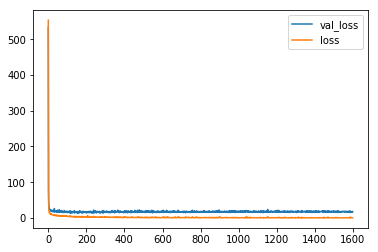

In [12]:
pd.DataFrame(history.history).plot()

## Let's use callbacks

Keras contains a callback mechanism allows to call your own function after each epoch, before each epoch, after each batch, etc.

Also Keras includes a bunch of predefined callbacks, for example for checkpining, early stopping, learning rate decay...

In [13]:
from keras_tqdm import TQDMNotebookCallback

In [14]:
model = Sequential([
    Dense(len(x_cols), input_dim=len(x_cols), kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal')
])

model.compile('adam', loss='mean_squared_error')

# set up callbacks
!rm -rf /tmp/checkpoints
!mkdir /tmp/checkpoints

checkpointer = ModelCheckpoint('/tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5')
logger = CSVLogger('/tmp/log.csv')

history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=1000,
                    verbose=0,
                    callbacks=[checkpointer, logger, TQDMNotebookCallback()],
                    validation_data=(X_valid, y_valid))

In [15]:
y_pred = model.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

MSE: 11.234004480331015
R^2: 0.8905588661171461


### Load and compile trained model

In [27]:
from keras.models import load_model

model = load_model('/tmp/checkpoints/weights.01-631.68.hdf5')
model.compile('adam', 'mean_squared_error')

## Let's use cross validation

In [16]:
from keras.layers import Dropout

In [ ]:
X, y = boston_df[x_cols].values, boston_df['y'].values


def build_fn():
    model = Sequential([
        Dense(32, input_dim=len(x_cols), kernel_initializer='normal', activation='relu'),
        Dropout(0.5),
        Dense(16, kernel_initializer='normal', activation='relu'),
        Dense(1, kernel_initializer='normal')
    ])
    
    model.compile('adam', loss='mean_squared_error')
    
    return model


estimators = [
    ('standardize', StandardScaler()),
    ('mlp', KerasRegressor(build_fn=build_fn, epochs=500, batch_size=5, verbose=0))
]

pipeline = Pipeline(estimators)

kfold = KFold(n_splits=5, random_state=1234)
results = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2', n_jobs=1)

In [ ]:
print('R^2:', results.mean())

## Excersize: play with NN structure. Try a deepper network and a wider ones.